In [1]:
import itertools
from collections import OrderedDict
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cycler import cycler


def filled_hist(ax, edges, values, bottoms=None, orientation='v',
                **kwargs):
    """
    Draw a histogram as a stepped patch.

    Extra kwargs are passed through to `fill_between`

    Parameters
    ----------
    ax : Axes
        The axes to plot to

    edges : array
        A length n+1 array giving the left edges of each bin and the
        right edge of the last bin.

    values : array
        A length n array of bin counts or values

    bottoms : scalar or array, optional
        A length n array of the bottom of the bars.  If None, zero is used.

    orientation : {'v', 'h'}
       Orientation of the histogram.  'v' (default) has
       the bars increasing in the positive y-direction.

    Returns
    -------
    ret : PolyCollection
        Artist added to the Axes
    """
    print(orientation)
    if orientation not in 'hv':
        raise ValueError("orientation must be in {{'h', 'v'}} "
                         "not {o}".format(o=orientation))

    kwargs.setdefault('step', 'post')
    edges = np.asarray(edges)
    values = np.asarray(values)
    if len(edges) - 1 != len(values):
        raise ValueError('Must provide one more bin edge than value not: '
                         'len(edges): {lb} len(values): {lv}'.format(
                             lb=len(edges), lv=len(values)))

    if bottoms is None:
        bottoms = 0
    bottoms = np.broadcast_to(bottoms, values.shape)

    values = np.r_[values, values[-1]]
    bottoms = np.r_[bottoms, bottoms[-1]]
    if orientation == 'h':
        return ax.fill_betweenx(edges, values, bottoms,
                                **kwargs)
    elif orientation == 'v':
        return ax.fill_between(edges, values, bottoms,
                               **kwargs)
    else:
        raise AssertionError("you should never be here")


def stack_hist(ax, stacked_data, sty_cycle, bottoms=None,
               hist_func=None, labels=None,
               plot_func=None, plot_kwargs=None):
    """
    ax : axes.Axes
        The axes to add artists too

    stacked_data : array or Mapping
        A (N, M) shaped array.  The first dimension will be iterated over to
        compute histograms row-wise

    sty_cycle : Cycler or operable of dict
        Style to apply to each set

    bottoms : array, optional
        The initial positions of the bottoms, defaults to 0

    hist_func : callable, optional
        Must have signature `bin_vals, bin_edges = f(data)`.
        `bin_edges` expected to be one longer than `bin_vals`

    labels : list of str, optional
        The label for each set.

        If not given and stacked data is an array defaults to 'default set {n}'

        If stacked_data is a mapping, and labels is None, default to the keys
        (which may come out in a random order).

        If stacked_data is a mapping and labels is given then only
        the columns listed by be plotted.

    plot_func : callable, optional
        Function to call to draw the histogram must have signature:

          ret = plot_func(ax, edges, top, bottoms=bottoms,
                          label=label, **kwargs)

    plot_kwargs : dict, optional
        Any extra kwargs to pass through to the plotting function.  This
        will be the same for all calls to the plotting function and will
        over-ride the values in cycle.

    Returns
    -------
    arts : dict
        Dictionary of artists keyed on their labels
    """
    # deal with default binning function
    if hist_func is None:
        hist_func = np.histogram

    # deal with default plotting function
    if plot_func is None:
        plot_func = filled_hist

    # deal with default
    if plot_kwargs is None:
        plot_kwargs = {}
    print(plot_kwargs)
    try:
        l_keys = stacked_data.keys()
        label_data = True
        if labels is None:
            labels = l_keys

    except AttributeError:
        label_data = False
        if labels is None:
            labels = itertools.repeat(None)

    if label_data:
        loop_iter = enumerate((stacked_data[lab], lab, s)
                              for lab, s in zip(labels, sty_cycle))
    else:
        loop_iter = enumerate(zip(stacked_data, labels, sty_cycle))

    arts = {}
    for j, (data, label, sty) in loop_iter:
        if label is None:
            label = 'dflt set {n}'.format(n=j)
        label = sty.pop('label', label)
        vals, edges = hist_func(data)
        if bottoms is None:
            bottoms = np.zeros_like(vals)
        top = bottoms + vals
        print(sty)
        sty.update(plot_kwargs)
        print(sty)
        ret = plot_func(ax, edges, top, bottoms=bottoms,
                        label=label, **sty)
        bottoms = top
        arts[label] = ret
    ax.legend(fontsize=10)
    return arts


# set up histogram function to fixed bins
edges = np.linspace(-3, 3, 20, endpoint=True)
hist_func = partial(np.histogram, bins=edges)

# set up style cycles
color_cycle = cycler(facecolor=plt.rcParams['axes.prop_cycle'][:4])
label_cycle = cycler(label=['set {n}'.format(n=n) for n in range(4)])
hatch_cycle = cycler(hatch=['/', '*', '+', '|'])

# Fixing random state for reproducibility
np.random.seed(19680801)

stack_data = np.random.randn(4, 12250)
dict_data = OrderedDict(zip((c['label'] for c in label_cycle), stack_data))


{}
{'facecolor': '#1f77b4', 'hatch': '/'}
{'facecolor': '#1f77b4', 'hatch': '/'}
v
{'facecolor': '#ff7f0e', 'hatch': '*'}
{'facecolor': '#ff7f0e', 'hatch': '*'}
v
{'facecolor': '#2ca02c', 'hatch': '+'}
{'facecolor': '#2ca02c', 'hatch': '+'}
v
{'facecolor': '#d62728', 'hatch': '|'}
{'facecolor': '#d62728', 'hatch': '|'}
v
{'edgecolor': 'w', 'orientation': 'h'}
{'facecolor': '#1f77b4'}
{'facecolor': '#1f77b4', 'edgecolor': 'w', 'orientation': 'h'}
h
{'facecolor': '#ff7f0e'}
{'facecolor': '#ff7f0e', 'edgecolor': 'w', 'orientation': 'h'}
h
{'facecolor': '#2ca02c'}
{'facecolor': '#2ca02c', 'edgecolor': 'w', 'orientation': 'h'}
h
{'facecolor': '#d62728'}
{'facecolor': '#d62728', 'edgecolor': 'w', 'orientation': 'h'}
h


Text(0, 0.5, 'x')

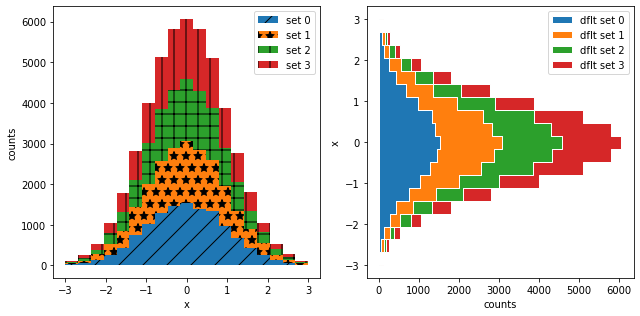

In [2]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)
arts = stack_hist(ax1, stack_data, color_cycle + label_cycle + hatch_cycle,
                  hist_func=hist_func)

arts = stack_hist(ax2, stack_data, color_cycle,
                  hist_func=hist_func,
                  plot_kwargs=dict(edgecolor='w', orientation='h'))
ax1.set_ylabel('counts')
ax1.set_xlabel('x')
ax2.set_xlabel('counts')
ax2.set_ylabel('x')


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
import matplotlib.pylab as plt

In [11]:
%matplotlib inline

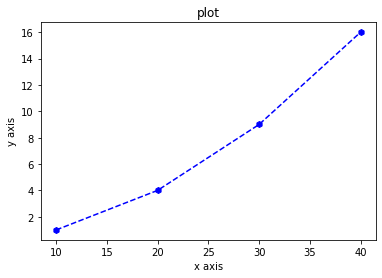

In [30]:
plt.title('plot')
plt.plot([10,20,30,40],[1,4,9,16],'bh--')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.show()

([<matplotlib.axis.XTick at 0x20ef9ffda88>,
 <a list of 5 Text xticklabel objects>)

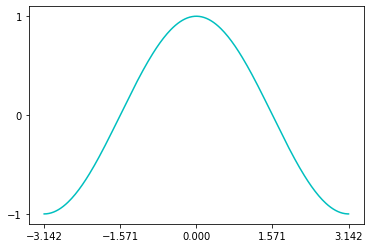

In [51]:
x=np.linspace(-np.pi,np.pi,256)
c=np.cos(x)
plt.plot(x,c,'c')
plt.yticks([-1,0,1])
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])

In [54]:
t=np.arange(0,5,0.2)
t

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8])

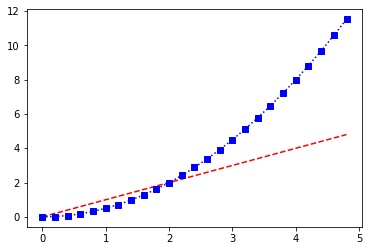

In [59]:
plt.plot(t,t,'r--',t,0.5*t**2,'bs:')

([<matplotlib.axis.XTick at 0x20efa25fe48>,
 <a list of 5 Text xticklabel objects>)

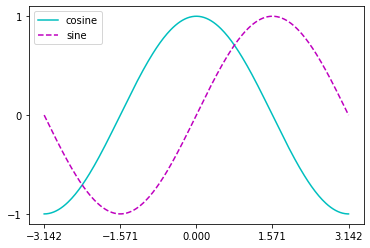

In [77]:
x=np.linspace(-np.pi,np.pi,256)
c,s=np.cos(x),np.sin(x)
plt.plot(x,c,'c-',label='cosine')
plt.plot(x,s,'m--',label='sine')
plt.legend(loc=0)
plt.yticks([-1,0,1])
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])

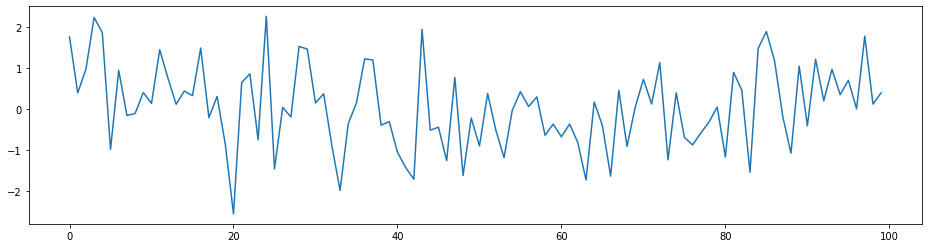

In [84]:
np.random.seed(0)
f1=plt.figure(figsize=(16,4))
plt.plot(np.random.randn(100))
plt.show()

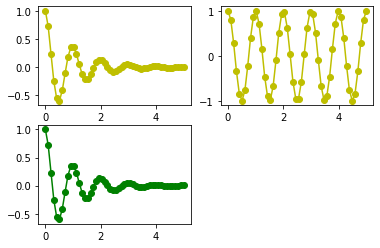

In [98]:
x1=np.linspace(0.0,5.0)
x2=np.linspace(0.0,5.0)
y1=np.cos(2*np.pi*x1)*np.exp(-x1)
y2=np.cos(2*np.pi*x1)
ax1=plt.subplot(2,2,1)
plt.plot(x1,y1,'yo-')

ax2=plt.subplot(2,2,2)
plt.plot(x1,y2,'yo-')

ax3=plt.subplot(2,2,3)
plt.plot(x2,y1,'go-')

#plt.tight_layout()

In [109]:
y=[2,3,1]
x=['가','나','다']

<BarContainer object of 3 artists>

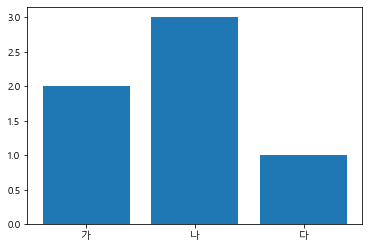

In [110]:
plt.bar(x,y)

In [108]:
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

<StemContainer object of 3 artists>

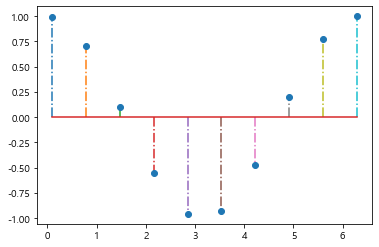

In [113]:
x=plt.linspace(0.1,2*np.pi,10)
plt.stem(x,np.cos(x),'-.')

([<matplotlib.patches.Wedge at 0x20ef851ee48>,
 [Text(-0.5901876713511441, 1.158308470393407, '취업'),
  Text(-1.0461621424642782, -0.3399187721714579, '결혼'),
  Text(0.9801072140121813, -0.4993894763020948, '출산'),
  Text(0.33991864973549485, 1.0461621822461364, '건강')],
 [Text(-0.3631924131391656, 0.7128052125497888, '15.0%'),
  Text(-0.5706338958896062, -0.18541023936624976, '30.0%'),
  Text(0.5346039349157352, -0.27239425980114257, '45.0%'),
  Text(0.1854101725829972, 0.5706339175888016, '10.0%')])

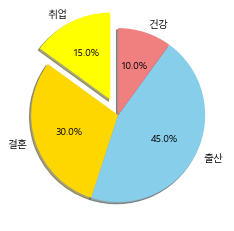

In [128]:
labels=['취업','결혼','출산','건강']
sizes=[15,30,45,10]
colors=['yellow','gold','skyblue','lightcoral']
ex=(0.2,0,0,0)
plt.pie(sizes,explode=ex,autopct='%.1f%%',labels=labels,colors=colors,shadow=True,startangle=90)

array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 2.000e+00,
       2.000e+00, 7.000e+00, 6.000e+00, 4.000e+00, 1.800e+01, 2.300e+01,
       2.200e+01, 4.600e+01, 4.400e+01, 6.300e+01, 7.700e+01, 9.700e+01,
       1.170e+02, 1.430e+02, 1.780e+02, 2.230e+02, 2.810e+02, 3.610e+02,
       4.100e+02, 5.320e+02, 5.880e+02, 7.460e+02, 8.600e+02, 9.660e+02,
       1.138e+03, 1.286e+03, 1.488e+03, 1.669e+03, 1.780e+03, 2.107e+03,
       2.284e+03, 2.432e+03, 2.741e+03, 2.849e+03, 3.064e+03, 3.129e+03,
       3.368e+03, 3.438e+03, 3.526e+03, 3.655e+03, 3.616e+03, 3.597e+03,
       3.651e+03, 3.631e+03, 3.467e+03, 3.308e+03, 3.225e+03, 3.133e+03,
       2.958e+03, 2.665e+03, 2.566e+03, 2.397e+03, 2.130e+03, 1.997e+03,
       1.731e+03, 1.560e+03, 1.340e+03, 1.114e+03, 9.650e+02, 9.340e+02,
       7.470e+02, 6.300e+02, 5.040e+02, 4.940e+02, 3.940e+02, 2.720e+02,
       2.980e+02, 1.880e+02, 1.620e+02, 1.170e+02, 

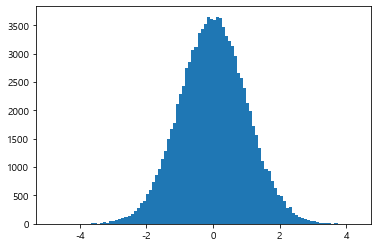

In [140]:
x=np.random.randn(100000)
arr,bins,patches=plt.hist(x,bins=100)
arr

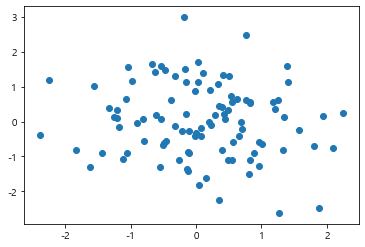

In [147]:
x=np.random.normal(0,1,100)
y=np.random.normal(0,1,100)
plt.scatter(x,y)

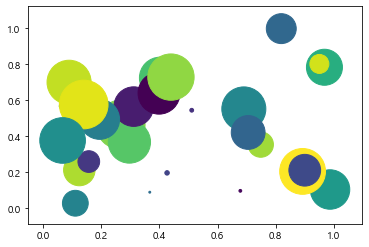

In [159]:
w=np.random.rand(30)
x=np.random.rand(30)
y=np.random.rand(30)
z=(50*np.random.rand(30))**2
plt.scatter(x,y,s=z,c=w)

In [171]:
from sklearn.datasets import load_digits as ld
digits=ld()
x=digits.images[4]
x

array([[ 0.,  0.,  0.,  1., 11.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  7.,  8.,  0.,  0.,  0.],
       [ 0.,  0.,  1., 13.,  6.,  2.,  2.,  0.],
       [ 0.,  0.,  7., 15.,  0.,  9.,  8.,  0.],
       [ 0.,  5., 16., 10.,  0., 16.,  6.,  0.],
       [ 0.,  4., 15., 16., 13., 16.,  1.,  0.],
       [ 0.,  0.,  0.,  3., 15., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  2., 16.,  4.,  0.,  0.]])

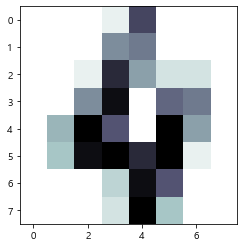

In [172]:
plt.imshow(x,cmap=plt.cm.bone_r)

In [177]:
import seaborn as sns
anscombe=sns.load_dataset('anscombe')
anscombe

,dataset,x,y
0,I,10.0,8.04
1,I,8.0,6.95
2,I,13.0,7.58
3,I,9.0,8.81
4,I,11.0,8.33
5,I,14.0,9.96
6,I,6.0,7.24
7,I,4.0,4.26
8,I,12.0,10.84
9,I,7.0,4.82


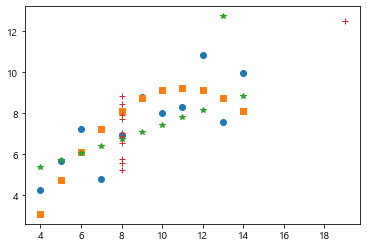

In [193]:
d1=anscombe[anscombe.dataset=='I']
d2=anscombe[anscombe.dataset=='II']
d3=anscombe[anscombe.dataset=='III']
d4=anscombe[anscombe.dataset=='IV']
plt.plot(d1['x'],d1['y'],'o')
plt.plot(d2['x'],d2['y'],'s')
plt.plot(d3['x'],d3['y'],'*')
plt.plot(d4['x'],d4['y'],'+')
fig=plt.figure()

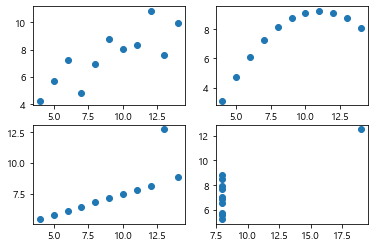

In [201]:
fig=plt.figure()
axes1=fig.add_subplot(2,2,1)
axes2=fig.add_subplot(2,2,2)
axes3=fig.add_subplot(2,2,3)
axes4=fig.add_subplot(2,2,4)
axes1.plot(d1['x'],d1['y'],'o')
axes2.plot(d2['x'],d2['y'],'o')
axes3.plot(d3['x'],d3['y'],'o')
axes4.plot(d4['x'],d4['y'],'o')

In [202]:
axes1.set_title('dataset1')
axes2.set_title('dataset2')
axes3.set_title('dataset3')
axes4.set_title('dataset4')

Text(0.5, 1, 'dataset4')

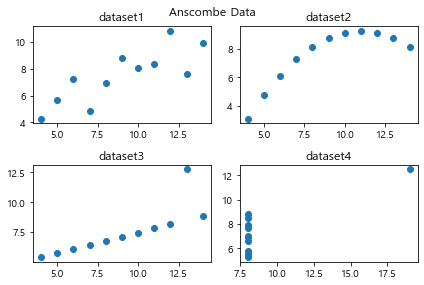

In [206]:
fig.tight_layout()
fig.suptitle('Anscombe Data')
fig

In [211]:
tips=sns.load_dataset('tips')


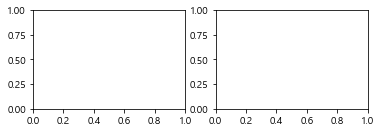

In [219]:
fig=plt.figure()
axes1=fig.add_subplot(2,2,1)
axes2=fig.add_subplot(2,2,2)

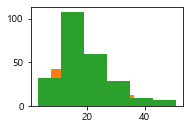

In [216]:
axes1.hist(tips['total_bill'],bins=6)
fig

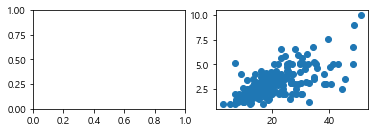

In [220]:
axes2.scatter(tips['total_bill'],tips['tip'])
fig

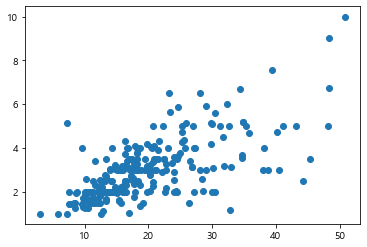

In [222]:
scPlot=plt.figure()
axes1=scPlot.add_subplot(1,1,1)
axes1.scatter(tips['total_bill'],tips['tip'])

TypeError: '(0       True
1      False
2      False
3      False
4       True
       ...  
239    False
240     True
241    False
242    False
243     True
Name: sex, Length: 244, dtype: bool, 0      False
1       True
2       True
3       True
4      False
       ...  
239     True
240    False
241     True
242     True
243    False
Name: sex, Length: 244, dtype: bool)' is an invalid key

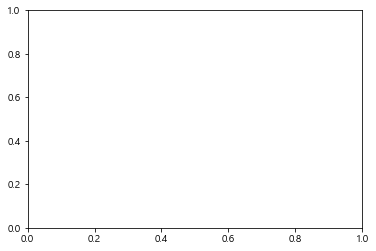

In [231]:
boxPlot=plt.figure()
axes1=boxPlot.add_subplot(1,1,1)
axes1.boxplot(tips[tips.sex=='Female'].tip, tips[tips.sex=='Male'].tip)